# Import All Libraries

In [1]:
import os
import shutil
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow
import keras
from collections import deque
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from keras.layers import *
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.utils import plot_model

# Visualize The Data

In [2]:
from IPython.display import HTML
from base64 import b64encode

In [3]:
def playVideo(filepath):
    html = ''
    video = open(filepath, 'rb').read()
    src = 'data:video/mp4;base64' + b64encode(video).decode()
    html += '<video width=640 muted controls autoplay loop><source src="%s" type="video/mp4"></video>' % src
    return HTML(html)

In [4]:
parkinson_dir = 'D:\\KAMPUS\\UGM\\Perlombaan\\PKM2023\\code\\model\\examples\\dataset\\parkinson'
stroke_dir = 'D:\\KAMPUS\\UGM\\Perlombaan\\PKM2023\\code\\model\\examples\\dataset\\stroke'
normal_dir = 'D:\\KAMPUS\\UGM\\Perlombaan\\PKM2023\\code\\model\\examples\\dataset\\normal'

parkinson_files_names_list = os.listdir(parkinson_dir)
stroke_files_names_list = os.listdir(stroke_dir)
normal_files_names_list = os.listdir(normal_dir)

Random_parkinson_Video = random.choice(parkinson_files_names_list)
Random_stroke_Video = random.choice(stroke_files_names_list)
Random_normal_Video = random.choice(normal_files_names_list)

In [5]:
# playVideo(f"{NonViolenceVideos_dir/{Random_NonViolence_Video}}")

In [6]:
# playVideo(f"{ViolenceVideos_dir}/{Random_Violence_Video}")

# Extracting Frames

In [7]:
IMAGE_HEIGHT, IMAGE_WIDTH = 64,64

SEQUENCE_LENGTH = 16

DATASET_DIR = 'D:\\KAMPUS\\UGM\\Perlombaan\\PKM2023\\code\\model\\examples\\dataset'

CLASSES_LIST = ["parkinson", "stroke", "normal"]

In [8]:
def framesExtraction(video_path):
    frames_list = []

    video_reader = cv2.VideoCapture(video_path)

    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        success, frame = video_reader.read()

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        normalized_frame = resized_frame / 255

        frames_list.append(normalized_frame)
    
    video_reader.release()

    return frames_list

# Creating The Data

In [9]:
def createDataset():
    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')

        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            frames = framesExtraction(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.asarray(labels)

    return features, labels, video_files_paths

In [10]:
features , labels, video_file_paths = createDataset()

Extracting Data of Class: parkinson
Extracting Data of Class: stroke
Extracting Data of Class: normal


In [11]:
np.save("features.npy", features)
np.save("labels.npy", labels)
np.save("video_files_paths.npy", video_file_paths)

In [12]:
features, labels, video_file_paths = np.load("features.npy"), np.load("labels.npy"), np.load("video_files_paths.npy")

# Encoding and Splitting Training-Testing Sets

In [13]:
one_hot_encoded_labels = to_categorical(labels)

In [14]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size=0.2,shuffle=True, random_state=42)

In [15]:
print(features_train.shape, labels_train.shape)
print(features_test.shape, labels_test.shape)

(54, 16, 64, 64, 3) (54, 3)
(14, 16, 64, 64, 3) (14, 3)


# Importing MobileNet and Fine-Tuning

In [16]:
from keras.applications.mobilenet_v2 import MobileNetV2

mobilenet = MobileNetV2(include_top=False, weights="imagenet")

mobilenet.trainable=True

for layer in mobilenet.layers[:-40]:
    layer.trainable=False

# mobilenet.summary()

C:\Users\Ryan\AppData\Local\Temp\ipykernel_28720\4281460135.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNetV2(include_top=False, weights="imagenet")


In [17]:
def createModel():
    model = Sequential()

    model.add(Input(shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(mobilenet))

    model.add(Dropout(0.25))

    model.add(TimeDistributed(Flatten()))

    lstm_fw = LSTM(units = 32)
    lstm_bw = LSTM(units=32, go_backwards=True)

    model.add(Bidirectional(lstm_fw, backward_layer=lstm_bw))

    model.add(Dropout(0.25))

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(len(CLASSES_LIST), activation='softmax'))

    model.summary()

    return model

In [18]:
MoBiLSTM_model = createModel()
# plot_model(MoBiLSTM_model, to_file='MoBiLSTM_model_structure_plot.png', show_shapes=True, show_layer_names=True)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ ?                      │     2,257,984 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 1,681,536 (6.41 MB)

 Non-trainable params: 576,448 (2.20 MB)

In [19]:
from tensorflow.keras.optimizers import Adam

early_stopping_callback = EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
reduce_lr = tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.6,
                                                  patience=5,
                                                  min_lr=0.00005,
                                                  verbose=2)
 
# Compiling the model 
MoBiLSTM_model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate=0.0001), metrics = ["accuracy"])
 
# Fitting the model 
MobBiLSTM_model_history = MoBiLSTM_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 8 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback,reduce_lr])

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 160s 5s/step - accuracy: 0.3848 - loss: 1.0934 - val_accuracy: 0.1818 - val_loss: 1.1186 - learning_rate: 1.0000e-04
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 416ms/step - accuracy: 0.1692 - loss: 1.1487 - val_accuracy: 0.2727 - val_loss: 1.0986 - learning_rate: 1.0000e-04
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 401ms/step - accuracy: 0.2402 - loss: 1.1768 - val_accuracy: 0.2727 - val_loss: 1.0939 - learning_rate: 1.0000e-04
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 407ms/step - accuracy: 0.3114 - loss: 1.1589 - val_accuracy: 0.3636 - val_loss: 1.0996 - learning_rate: 1.0000e-04
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 411ms/step - accuracy: 0.4546 - loss: 1.0914 - val_accuracy: 0.3636 - val_loss: 1.0931 - learning_rate: 1.0000e-04
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 414ms/step - accuracy: 0.2227 - loss: 1.1213 - val_accuracy: 0.4545 - val_loss: 1.0909 - learning_rate: 1.0000e-04
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 403ms/step - accuracy: 0.4575 - loss: 

In [20]:
model_evaluation_history = MoBiLSTM_model.evaluate(features_test, labels_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.6429 - loss: 1.0834


# Model Evaluation

In [21]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label=metric_name_1)
    plt.plot(epochs, metric_value_2, 'orange', label=metric_name_2)

    plt.title(str(plot_name))

    plt.legend()

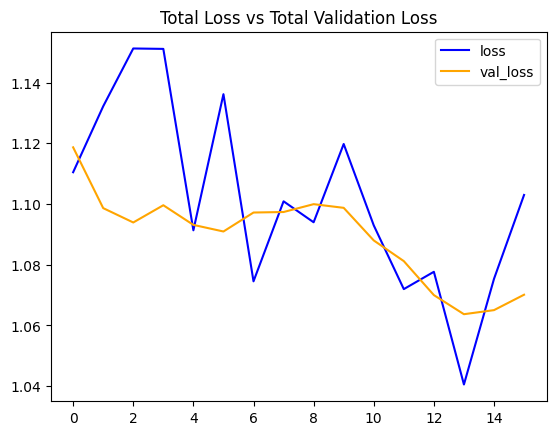

In [22]:
plot_metric(MobBiLSTM_model_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

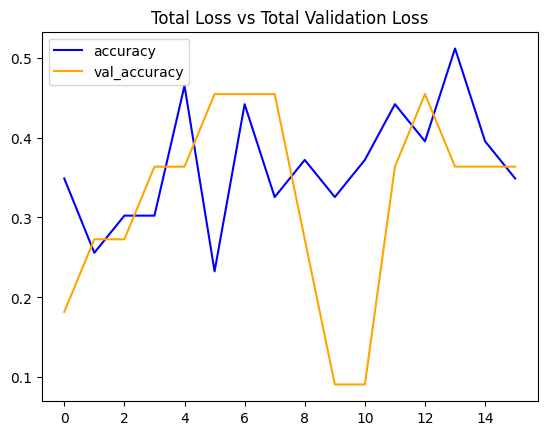

In [23]:
plot_metric(MobBiLSTM_model_history, 'accuracy', 'val_accuracy', 'Total Loss vs Total Validation Loss')

# Predicting the Test Set

In [24]:
labels_predict = MoBiLSTM_model.predict(features_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step


In [25]:
labels_predict = np.argmax(labels_predict, axis=1)
labels_test_normal = np.argmax(labels_test, axis=1)

In [26]:
labels_test_normal.shape, labels_predict.shape

((14,), (14,))

# Accuracy Score

In [27]:
from sklearn.metrics import accuracy_score
AccScore = accuracy_score(labels_predict, labels_test_normal)
print('Accuracy Score is : ', AccScore)

Accuracy Score is :  0.6428571428571429


# Confusion Matrix

[Text(0, 0.5, 'parkinson'), Text(0, 1.5, 'stroke'), Text(0, 2.5, 'normal')]

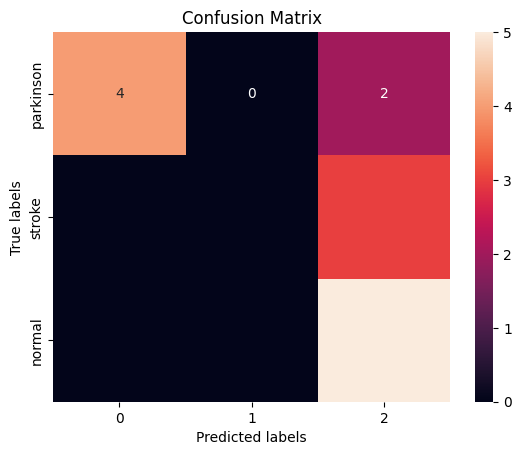

In [47]:
from sklearn.metrics import confusion_matrix

ax= plt.subplot()
cm=confusion_matrix(labels_test_normal, labels_predict)
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['0','1','2']); 
ax.yaxis.set_ticklabels(['parkinson', 'stroke', 'normal'])

# Classification Report

In [31]:
from sklearn.metrics import classification_report

ClassificationReport = classification_report(labels_test_normal,labels_predict)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       0.00      0.00      0.00         3
           2       0.50      1.00      0.67         5

    accuracy                           0.64        14
   macro avg       0.50      0.56      0.49        14
weighted avg       0.61      0.64      0.58        14



c:\Users\Ryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

# Prediction Frame by Frame

In [38]:
def predict_frames(video_file_path, output_file_path, SEQUENCE_LENGTH):
    
    # Read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)
 
    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
 
    # VideoWriter to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('m', 'p', '4', 'v'), 
                                    video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))
 
    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)
 
    # Store the predicted class in the video.
    predicted_class_name = ''
 
    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():
 
        ok, frame = video_reader.read() 
        
        if not ok:
            break
 
        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame 
        normalized_frame = resized_frame / 255
 
        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)
 
        # We Need at Least number of SEQUENCE_LENGTH Frames to perform a prediction.
        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:                        
 
            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = MoBiLSTM_model.predict(np.expand_dims(frames_queue, axis = 0))[0]
 
            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)
 
            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]
 
        # Write predicted class name on top of the frame.
        if predicted_class_name == "parkinson":
            cv2.putText(frame, predicted_class_name, (5, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 12)
        elif predicted_class_name == "stroke":
            cv2.putText(frame, predicted_class_name, (5, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 0, 255), 12)
        else:
            cv2.putText(frame, predicted_class_name, (5, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 12)
         
        # Write The frame into the disk using the VideoWriter
        video_writer.write(frame)                       
        
    video_reader.release()
    video_writer.release()

In [39]:
plt.style.use("default")

# To show Random Frames from the saved output predicted video (output predicted video doesn't show on the notebook but can be downloaded)
def show_pred_frames(pred_video_path): 

    plt.figure(figsize=(20,15))

    video_reader = cv2.VideoCapture(pred_video_path)

    # Get the number of frames in the video.
    frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Get Random Frames from the video then Sort it
    random_range = sorted(random.sample(range (SEQUENCE_LENGTH , frames_count ), 12))
        
    for counter, random_index in enumerate(random_range, 1):
        
        plt.subplot(5, 4, counter)

        # Set the current frame position of the video.  
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, random_index)
          
        ok, frame = video_reader.read() 

        if not ok:
          break 

        frame = cv2.cvtColor(frame , cv2.COLOR_BGR2RGB)

        plt.imshow(frame);ax.figure.set_size_inches(20,20);plt.tight_layout()
                            
    video_reader.release()


In [49]:
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)
 
output_video_file_path = f'{test_videos_directory}/Output-Test-Video.mp4'

In [53]:
# Specifying video to be predicted
input_video_file_path = ""

# Perform Prediction on the Test Video.
predict_frames(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

# Show random frames from the output video
show_pred_frames(output_video_file_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━

ValueError: Sample larger than population or is negative

<Figure size 2000x1500 with 0 Axes>